# Assignment Name: Geospatial Data Operations

Student Name: Sneha Dinesh Porwal

Student Id: 3739281

Date: 27 Jan, 2024

## Description

In this assignment, we analyze and visualize climate data for Ottawa, ON, from the GeoMET API, focusing on the vicinity of 560 Rochester St. Throughout 2011, we examine temperature patterns and precipitation trends, pinpoint the geographical location of weather observations, and calculate seasonal temperature averages. The analysis involves creating detailed plots to illustrate daily and seasonal variations using Python libraries such as OWSLib, pandas, matplotlib, and folium, which together facilitate a thorough exploration of the year's climatic behavior.


## Objective

The objective of this assignment is to analyze and visualize climate data for Ottawa, ON, specifically focusing on the area around '560 Rochester St', for the year 2011. This involves retrieving and processing data from the GeoMET API to identify the closest weather observation station, followed by an in-depth examination of temperature patterns and precipitation trends throughout the year. The assignment aims to create clear visual representations of these climate variables, including individual and combined temperature plots, cumulative precipitation charts, and interactive geospatial mapping of the observation station and address. Through this analysis, the project seeks to provide valuable insights into the local climatic conditions, demonstrating the application of geospatial and data visualization techniques in understanding environmental data.

In [2]:
# Import Packages
from owslib.ogcapi.features import Features
from geopy.geocoders import Nominatim
from osgeo import ogr, osr
import json
import pandas as pd

## Data Retrieval and Geolocation

The first step in our analysis involves retrieving climate data from the GeoMET API. We start by geolocating the address '560 Rochester St, Ottawa, ON, CA' to identify the closest observation station and define a buffer area for our data query.

In [3]:
# Initialize geolocator with a user agent for making geocode requests
geolocator = Nominatim(user_agent="my-staticVisualizationDemo1-application")

# Geocode the given address to retrieve latitude and longitude
# This uses the OpenStreetMap Nominatim service to convert the address into coordinates
location = geolocator.geocode("560 Rochester St, Ottawa, ON, CA")

# Extract the latitude and longitude from the location object
lat, lon = location.latitude, location.longitude

# Output the coordinates
# This confirms the geocoding was successful and shows the coordinates that will be used
print(f"Latitude: {lat}, Longitude: {lon}")

Latitude: 45.39864945, Longitude: -75.70611299803701


### Defining the Buffer Zone

With the geocoded coordinates, we set a buffer zone of 2 kilometers around the address. This buffer is instrumental in defining the area within which we will search for relevant climate data stations.

In [4]:
# Define the buffer size in kilometers and convert it to degrees
buffer = 2
buffer_deg_lat = buffer * 0.009  # Latitude conversion factor
buffer_deg_lon = buffer * 0.014  # Longitude conversion factor at 49th parallel

# Create the bounding box (bbox) for the data query
bbox = [lon - buffer_deg_lon, lat - buffer_deg_lat, lon + buffer_deg_lon, lat + buffer_deg_lat]

### Retrieving Climate Data

We utilize the OWSLib library to interface with the GeoMET API, requesting climate data within our defined bounding box for the entire year of 2011. This data will include key metrics such as temperature and precipitation.

In [5]:
# Initialize the OGC API Features client for the GeoMET API
apiFeat = Features("https://api.weather.gc.ca/")

# Try to retrieve the climate data for the specified bounding box and year
try:
    station_data = apiFeat.collection_items("climate-daily", bbox=bbox, LOCAL_YEAR=2011, limit=10000, PROVINCE_CODE='ON')
    # Check if features are present in the retrieved data
    if "features" in station_data and station_data["features"]:
        station_data_json = json.dumps(station_data, indent=2)
    else:
        print("No stations were found nearby. Please verify the coordinates.")
        station_data_json = None
except Exception as e:
    print(f"Error occurred: {e}")
    station_data_json = None

# Output the station data JSON or a message if no data was found
if station_data_json:
    print("Data retrieved successfully.")
else:
    print("No valid JSON data to process.")

Data retrieved successfully.


### Processing Retrieved Data

Upon successful retrieval of the climate data, we process it further to identify nearby observation stations. This involves loading the data into a GeoJSON format and applying spatial data processing techniques.

In [6]:
# Import necessary libraries for data processing
import os

# Check and process the JSON data if it's valid
if station_data_json:
    # Write the GeoJSON data to a file for spatial processing
    with open('temp_station_data.geojson', 'w') as file:
        file.write(station_data_json)

    # Load the GeoJSON file using OGR
    driver = ogr.GetDriverByName("GeoJSON")
    data_source = driver.Open('temp_station_data.geojson', 0)
    layer = data_source.GetLayer()

    # Retrieve the spatial reference from the data layer
    SRS_input = layer.GetSpatialRef()
    if not SRS_input:
        raise RuntimeError("Input spatial reference system is missing or invalid.")

    # Define the target spatial reference system (NAD83 / Statistics Canada Lambert)
    projection = 3347
    SRS_projected = osr.SpatialReference()
    SRS_projected.ImportFromEPSG(projection)
    transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

    # Create a point geometry for the geocoded address
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)
    point.Transform(transform)

    # Create a buffer around the point in meters
    buffer_meters = buffer * 1000
    point_buffer = point.Buffer(buffer_meters)

    # Initialize a list to store names of nearby stations
    nearby_stations = []

    # Iterate over features in the layer to find stations within the buffer
    for feature in layer:
        station_geom = feature.GetGeometryRef().Clone()
        station_geom.Transform(transform)
        if station_geom.Intersects(point_buffer):
            station_name = feature.GetField("STATION_NAME")
            nearby_stations.append(station_name)

    # Remove duplicates from the list of nearby stations
    unique_stations = list(set(nearby_stations))
    print("Nearby Stations:", unique_stations)
else:
    print("No valid JSON data to process.")

Nearby Stations: ['OTTAWA CDA', 'OTTAWA CDA RCS']


### Identifying the Closest Station

Upon identifying 'OTTAWA CDA' and 'OTTAWA CDA RCS' as nearby stations, we need to determine which of these is closest to our specified address. This step is crucial for ensuring that the data analyzed is as relevant and accurate as possible.

In [7]:
# Initialize a dictionary to store the coordinates of each unique station
station_coords = {}

# Retrieve coordinates for each station to determine their proximity
for station in unique_stations:
    try:
        # Request data for each station
        data = apiFeat.collection_items("climate-daily", bbox=bbox, STATION_NAME=station, LOCAL_YEAR=2011)

        # Extract coordinates from the first feature of each station
        if data["features"]:
            first_feature = data["features"][0]
            station_coords[station] = (first_feature["geometry"]["coordinates"][1], first_feature["geometry"]["coordinates"][0])
    except Exception as e:
        print(f"Error retrieving data for station {station}: {e}")

# Print the coordinates of each station
for station, coords in station_coords.items():
    print(f"{station}: Latitude = {coords[0]}, Longitude = {coords[1]}")

OTTAWA CDA: Latitude = 45.38333333333333, Longitude = -75.71666666666667
OTTAWA CDA RCS: Latitude = 45.38333333333333, Longitude = -75.71666666666667


### Choosing the Relevant Station

The retrieved coordinates reveal that 'OTTAWA CDA' and 'OTTAWA CDA RCS' share the same location. Given this, we can proceed with data from either station, as both are equally representative of the climate at the specified address.

In [8]:
# Select 'OTTAWA CDA' as the station for data collection
selected_station = 'OTTAWA CDA'
all_data = []

# Retrieve climate data specifically for the chosen station
try:
    data = apiFeat.collection_items("climate-daily", bbox=bbox, STATION_NAME=selected_station, LOCAL_YEAR=2011)

    # Process the retrieved data if present
    if data["features"]:
        records = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"]
            } for el in data["features"]
        ]
        all_data.extend(records)
        print(f"Station {selected_station}: {len(records)} records added.")
    else:
        print(f"No data found for station {selected_station}.")
except Exception as e:
    print(f"Error retrieving data for station {selected_station}: {e}")

# Create a DataFrame from the collected data
hdf1 = pd.DataFrame(all_data, columns=[
    "CLIMATE_IDENTIFIER", "STATION_NAME", "PROVINCE_CODE", "LOCAL_MONTH",
    "LOCAL_DAY", "LOCAL_DATE", "LOCAL_YEAR", "MIN_TEMPERATURE", "MAX_TEMPERATURE",
    "MEAN_TEMPERATURE", "TOTAL_PRECIPITATION"
])
hdf1

Station OTTAWA CDA: 500 records added.


,CLIMATE_IDENTIFIER,STATION_NAME,PROVINCE_CODE,LOCAL_MONTH,LOCAL_DAY,LOCAL_DATE,LOCAL_YEAR,MIN_TEMPERATURE,MAX_TEMPERATURE,MEAN_TEMPERATURE,TOTAL_PRECIPITATION
0,6105976,OTTAWA CDA,ON,1,1,2011-01-01 00:00:00,2011,1.7,7.7,4.7,4.2
1,6105976,OTTAWA CDA,ON,1,2,2011-01-02 00:00:00,2011,-2.2,1.2,-0.5,0.0
2,6105976,OTTAWA CDA,ON,1,3,2011-01-03 00:00:00,2011,-5.8,-2.0,-3.9,0.5
3,6105976,OTTAWA CDA,ON,1,4,2011-01-04 00:00:00,2011,-8.4,-3.1,-5.8,0.9
4,6105976,OTTAWA CDA,ON,1,5,2011-01-05 00:00:00,2011,-7.0,-3.8,-5.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
495,6105978,OTTAWA CDA RCS,ON,5,11,2011-05-11 00:00:00,2011,7.5,19.4,13.5,0.0
496,6105978,OTTAWA CDA RCS,ON,5,4,2011-05-04 00:00:00,2011,5.4,9.6,7.5,0.7
497,6105978,OTTAWA CDA RCS,ON,5,5,2011-05-05 00:00:00,2011,5.1,15.3,10.2,0.0
498,6105978,OTTAWA CDA RCS,ON,5,3,2011-05-03 00:00:00,2011,5.3,8.9,7.1,5.1


### Filtering Data for Consistency

To ensure consistency in our analysis, we filter the DataFrame to include data only from 'OTTAWA CDA'. This step is vital to maintain the focus of our assignment on the most relevant station.

In [9]:
# Filter the DataFrame to include only data from 'OTTAWA CDA'
hdf1 = hdf1[hdf1['STATION_NAME'] == 'OTTAWA CDA']
hdf1

,CLIMATE_IDENTIFIER,STATION_NAME,PROVINCE_CODE,LOCAL_MONTH,LOCAL_DAY,LOCAL_DATE,LOCAL_YEAR,MIN_TEMPERATURE,MAX_TEMPERATURE,MEAN_TEMPERATURE,TOTAL_PRECIPITATION
0,6105976,OTTAWA CDA,ON,1,1,2011-01-01 00:00:00,2011,1.7,7.7,4.7,4.2
1,6105976,OTTAWA CDA,ON,1,2,2011-01-02 00:00:00,2011,-2.2,1.2,-0.5,0.0
2,6105976,OTTAWA CDA,ON,1,3,2011-01-03 00:00:00,2011,-5.8,-2.0,-3.9,0.5
3,6105976,OTTAWA CDA,ON,1,4,2011-01-04 00:00:00,2011,-8.4,-3.1,-5.8,0.9
4,6105976,OTTAWA CDA,ON,1,5,2011-01-05 00:00:00,2011,-7.0,-3.8,-5.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
360,6105976,OTTAWA CDA,ON,10,22,2011-10-22 00:00:00,2011,6.7,10.9,8.8,0.0
361,6105976,OTTAWA CDA,ON,10,23,2011-10-23 00:00:00,2011,3.8,12.0,7.9,0.2
362,6105976,OTTAWA CDA,ON,10,24,2011-10-24 00:00:00,2011,1.3,14.7,8.0,1.7
363,6105976,OTTAWA CDA,ON,10,25,2011-10-25 00:00:00,2011,6.1,11.3,8.7,0.0


### Conclusion of Data Collection and Filtering

With the successful retrieval and filtering of climate data for 'OTTAWA CDA', we now have a focused dataset ready for detailed analysis. This dataset will form the basis of our subsequent temperature and precipitation visualizations, offering insights into the local climate of Ottawa, ON, for the year 2011.

## PART A. Static Visualization

### 1. Create individual plots for minimum, mean and maximum temperature, and a 4th plot of all temperatures in one plot using the subplot function and aligning the axes.

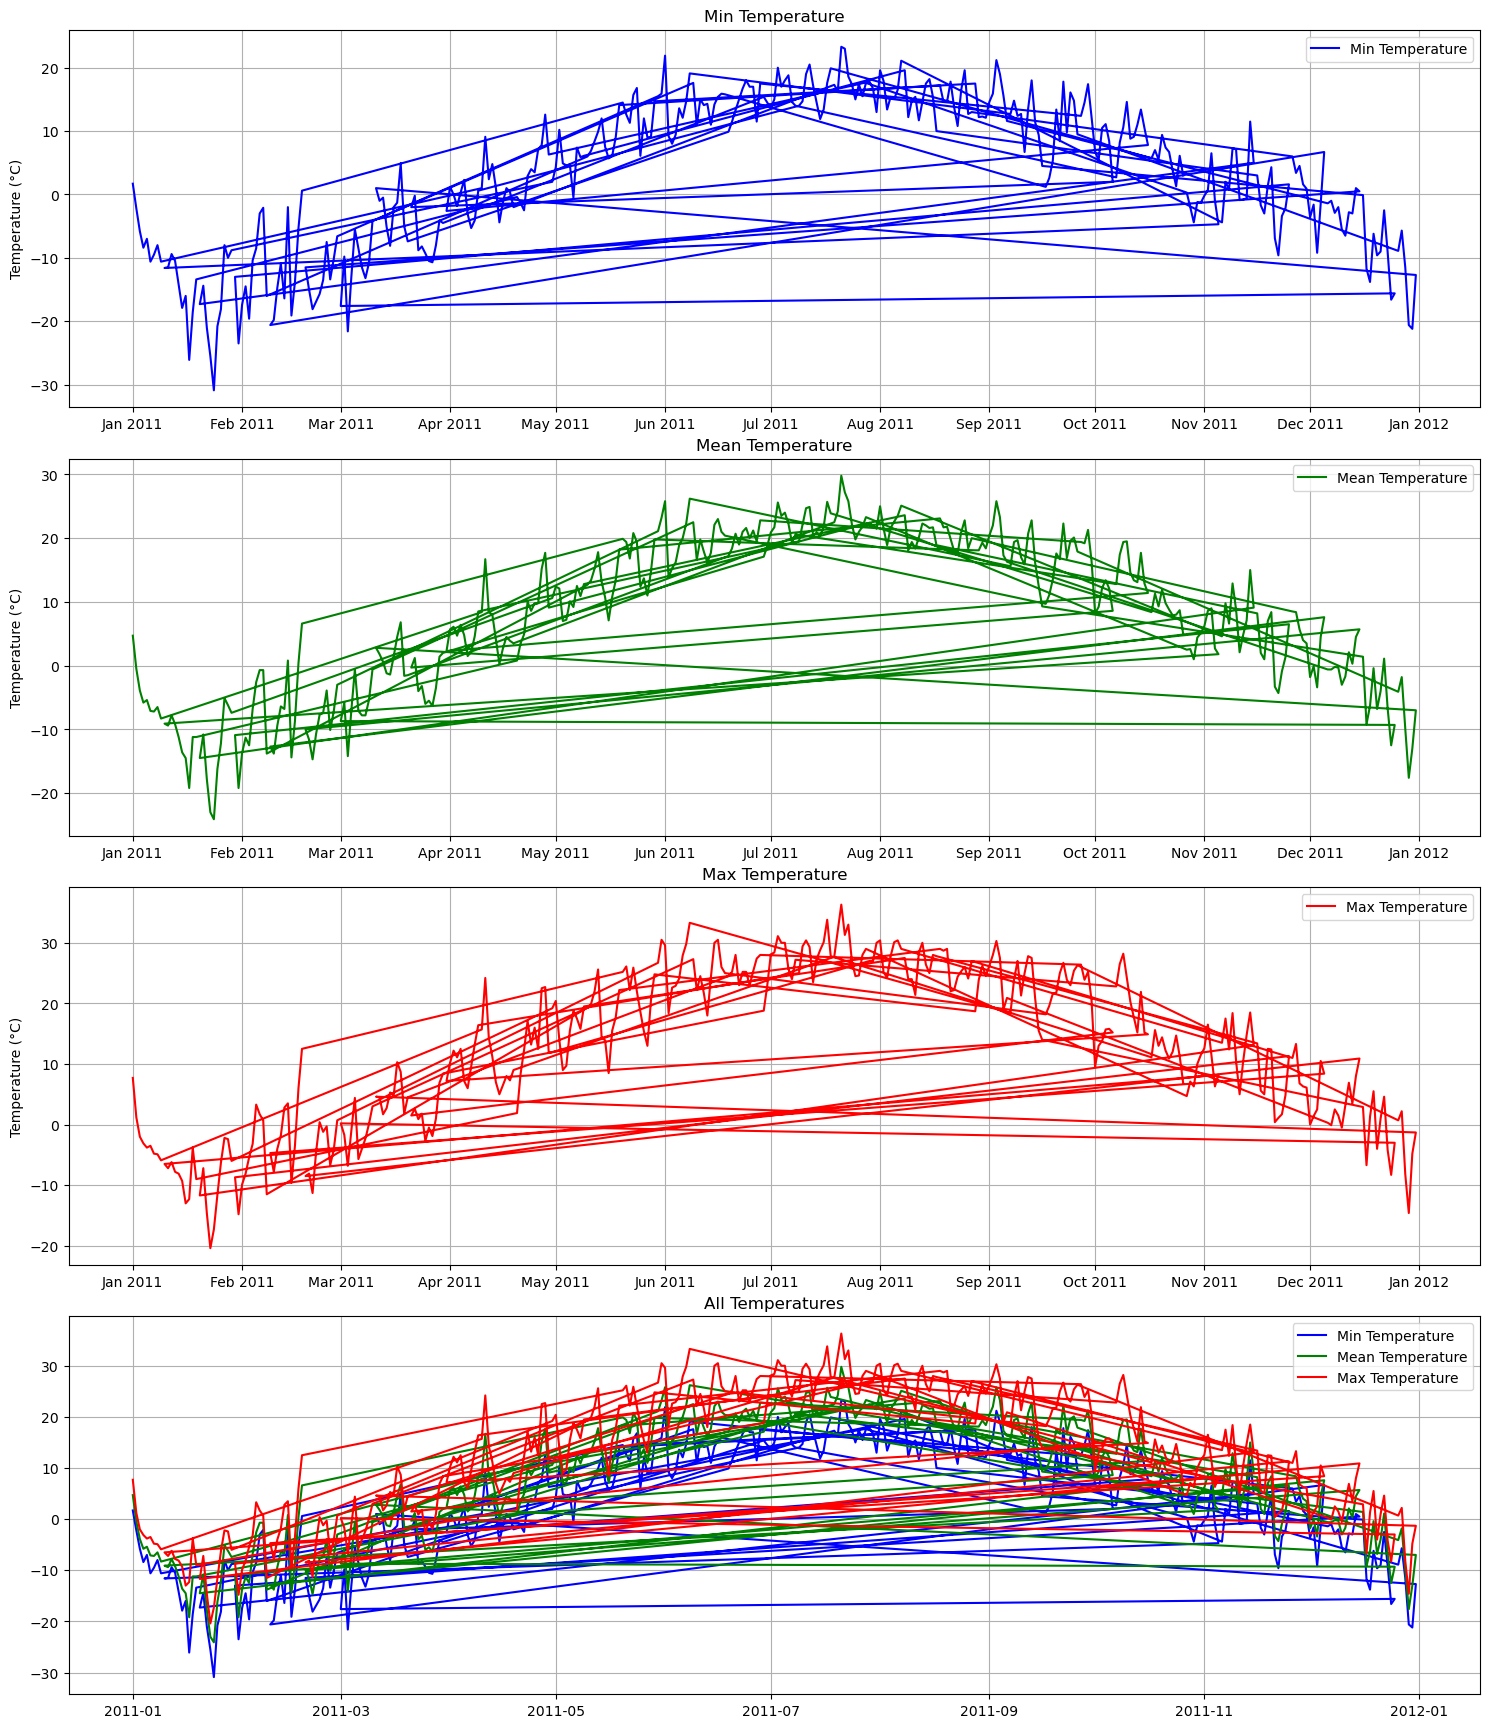

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure hdf1 is a standalone DataFrame to prevent any unintentional modifications to the original data
hdf1 = hdf1.copy()

# Convert the 'LOCAL_DATE' column to datetime for accurate plotting
hdf1['LOCAL_DATE'] = pd.to_datetime(hdf1['LOCAL_DATE'])

# Create subplots for individual and combined temperature plots
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=False)

# Define date formatting for the x-axis
date_format = mdates.DateFormatter('%b %Y')
month_locator = mdates.MonthLocator()

# Assign unique colors for each temperature plot
colors = ['blue', 'green', 'red']

# Plot each temperature type in separate subplots
for i, (temp, color) in enumerate(zip(['MIN_TEMPERATURE', 'MEAN_TEMPERATURE', 'MAX_TEMPERATURE'], colors)):
    axs[i].plot(hdf1['LOCAL_DATE'], hdf1[temp], label=temp.replace('_', ' ').title(), color=color)
    axs[i].set_title(temp.replace('_', ' ').title())
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].xaxis.set_major_locator(month_locator)
    axs[i].xaxis.set_major_formatter(date_format)
    axs[i].grid(True)

# Combine all temperature plots in the last subplot
axs[3].plot(hdf1['LOCAL_DATE'], hdf1['MIN_TEMPERATURE'], label='Min Temperature', color=colors[0])
axs[3].plot(hdf1['LOCAL_DATE'], hdf1['MEAN_TEMPERATURE'], label='Mean Temperature', color=colors[1])
axs[3].plot(hdf1['LOCAL_DATE'], hdf1['MAX_TEMPERATURE'], label='Max Temperature', color=colors[2])
axs[3].set_title('All Temperatures')
axs[3].legend()
axs[3].grid(True)

# Adjust layout for clarity and visibility of labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### Summary of the above ouput:

The temperature visualization section provided a clear depiction of the temperature dynamics in Ottawa for 2011. Key observations include:
- **Minimum Temperature Trends**: Showed significant fluctuations, particularly highlighting the colder temperatures in the winter months.
- **Mean Temperature Variations**: Offered a balanced view of the overall temperature changes throughout the year.
- **Maximum Temperature Peaks**: Illustrated the warmest days, especially during the summer.
- **Combined Temperature Plot**: Effectively synthesized all temperature data, offering a comprehensive perspective of seasonal changes.

These visualizations underscore the diverse temperature patterns characteristic of Ottawa's climate, from the chilly winters to the warm summers.


### 2. Plot the cumulative precipitation over the year.

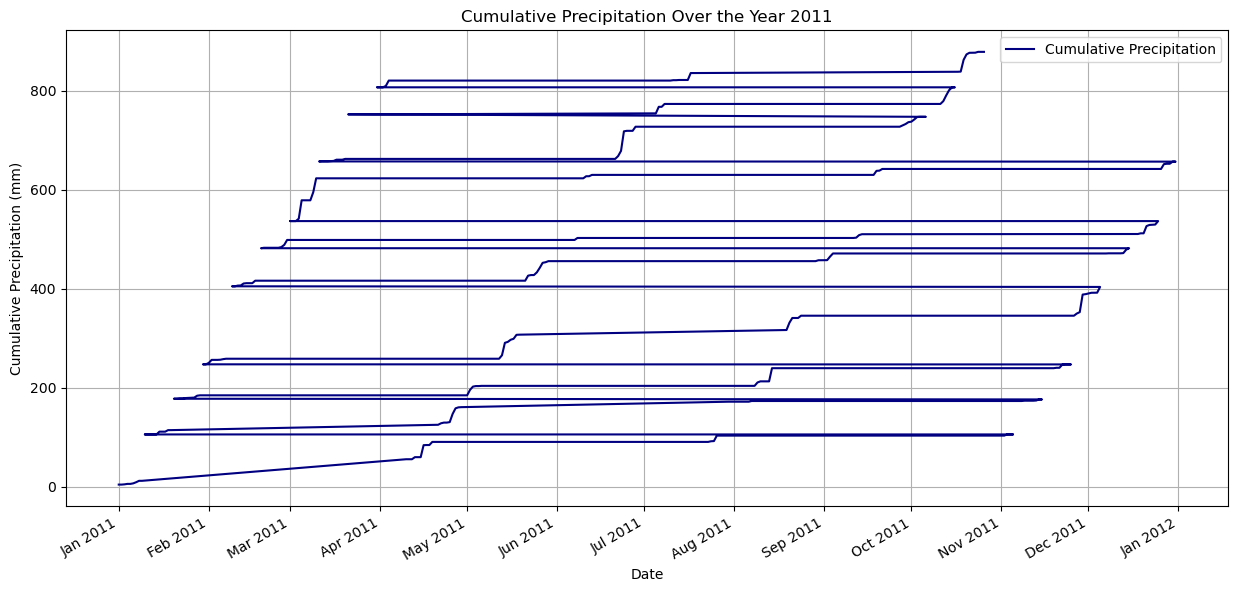

In [11]:
# Calculate the cumulative sum of precipitation
hdf1['CUMULATIVE_PRECIPITATION'] = hdf1['TOTAL_PRECIPITATION'].cumsum()

# Plot the cumulative precipitation over the year
plt.figure(figsize=(15, 7))
plt.plot(hdf1['LOCAL_DATE'], hdf1['CUMULATIVE_PRECIPITATION'], label='Cumulative Precipitation', color='navy')
plt.title('Cumulative Precipitation Over the Year 2011')
plt.xlabel('Date')
plt.ylabel('Cumulative Precipitation (mm)')
plt.legend()

# Format the x-axis to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # Auto-format for better readability
plt.grid(True)
plt.show()

### Summary of the above ouput:

The cumulative precipitation plot revealed the following:
- A steady increase in precipitation over the year, with noticeable upticks during certain months.
- This visualization highlights periods of heavier rainfall, contributing to our understanding of precipitation distribution throughout 2011.

The plot serves as an essential tool in assessing the wetness of the year, showcasing how precipitation accumulated over time.


### 3. Create a geographic map – plot the location of the closest observation station in a folium map using a custom marker with a pop up that provide some details of the station (e.g.: Station Name, Station Number, and Latitude, Longitude) and a different style marker at the address provided.

In [12]:
import folium

# Define the coordinates of the observation station and the provided address
station_lat = 45.3833
station_lon = -75.7167
station_name = "OTTAWA CDA"
station_number = "6105976"
address = "560 Rochester St, Ottawa, ON, CA"

# Create an interactive map centered around the observation station
map_ = folium.Map(location=[station_lat, station_lon], zoom_start=12)

# Add a custom marker for the observation station
folium.Marker(
    [station_lat, station_lon],
    popup=f"<b>Station Name:</b> {station_name}<br><b>Station Number:</b> {station_number}<br><b>Latitude:</b> {station_lat}<br><b>Longitude:</b> {station_lon}",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map_)

# Add a custom marker for the provided address
folium.Marker(
    [lat, lon],
    popup=f"<b>Address:</b> {address}<br><b>Latitude:</b> {round(lat, 4)}<br><b>Longitude:</b> {round(lon, 4)}",
    icon=folium.Icon(color='red', icon='home')
).add_to(map_)

# Display the interactive map
map_

### Summary of the above output:

The interactive map, enriched with Folium, provided these insights:
- The precise location of the Ottawa CDA observation station was visually marked, alongside the specified address.
- Custom markers and pop-ups enhanced the map's informational value, offering immediate context and data points such as station name and coordinates.
- This spatial representation was instrumental in bridging the gap between raw data and its geographical implications.

The map not only added a spatial dimension to our analysis but also enriched our understanding of the physical context of the climate data.

## PART B. Data Calculations

### Using the data you have downloaded in Part A. Calculate the average of the mean temperature for each season, using the following dates to denote seasonal boundaries:
#### Spring: March 20th
#### Summer: June 21st
#### Autumn/Fall: Sept 23
#### Winter: Dec 21th
### Create a function which generates a plot of each season showing the variation in mean temperature throughout the season and indicating the computed average mean temperature in the season. 

### Seasonal Temperature Analysis

This involves calculating the average mean temperature for each season and visualizing the temperature variation throughout each season. The seasons are defined by specific dates, allowing us to observe the climatic changes within these defined time frames.

In [59]:
# Function to classify each day into its corresponding season
def get_season(row):
    month, day = row['LOCAL_MONTH'], row['LOCAL_DAY']
    if (month, day) < (3, 20):
        return 'Winter'  # Before March 20
    elif (month, day) < (6, 21):
        return 'Spring'  # Before June 21
    elif (month, day) < (9, 23):
        return 'Summer'  # Before September 23
    elif (month, day) < (12, 21):
        return 'Autumn'  # Before December 21
    else:
        return 'Winter'  # On or after December 21

# Apply the season classification function to the DataFrame
hdf1['SEASON'] = hdf1.apply(get_season, axis=1)

# Calculate the average mean temperature for each season
seasonal_avg = hdf1.groupby('SEASON')['MEAN_TEMPERATURE'].mean()

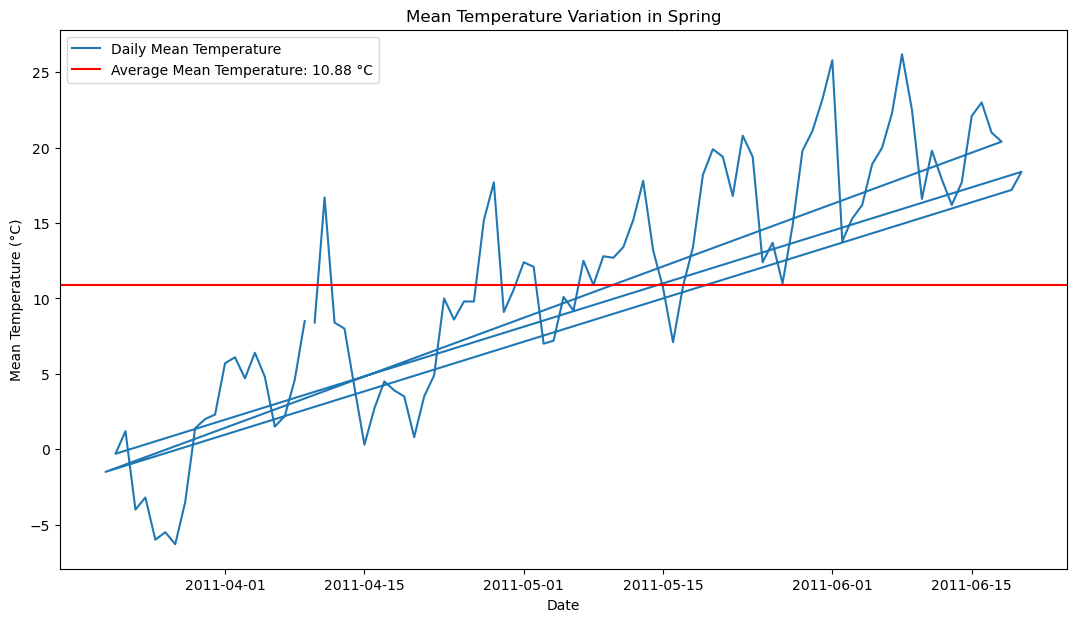

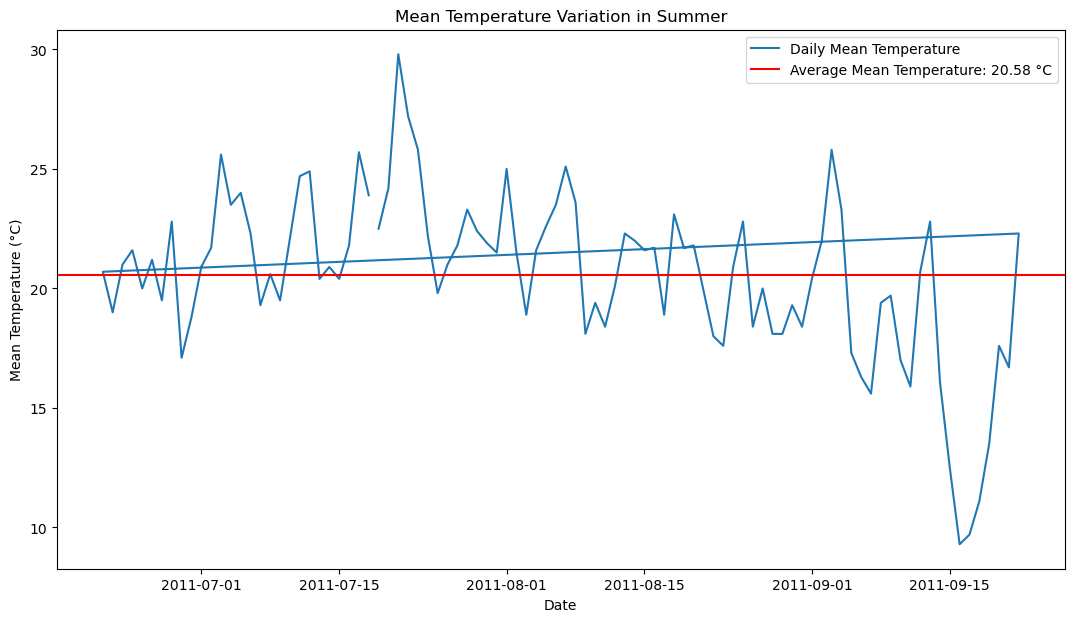

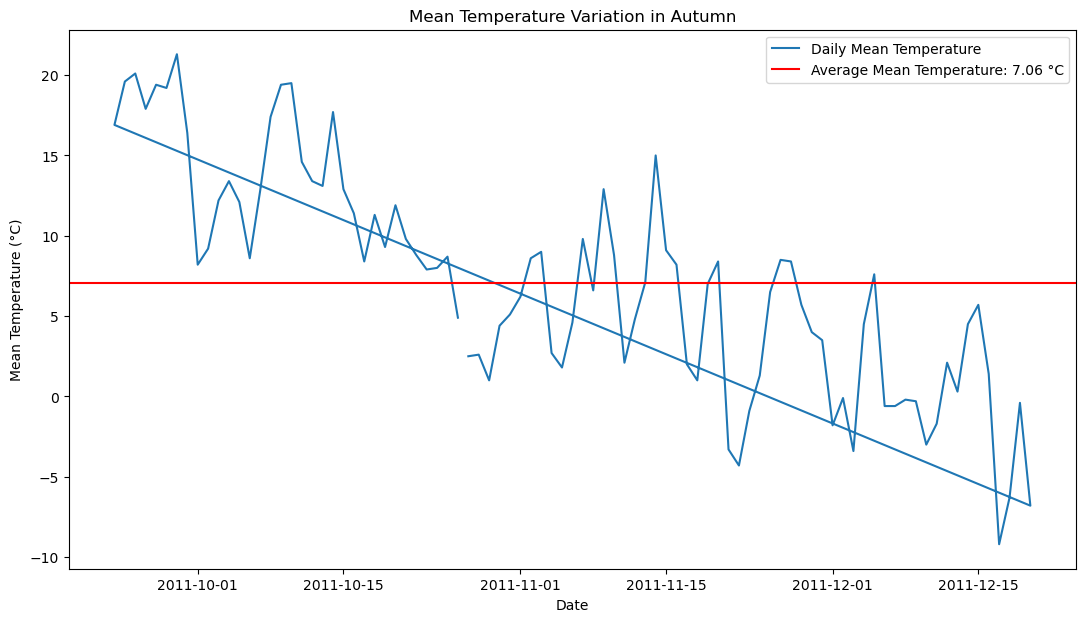

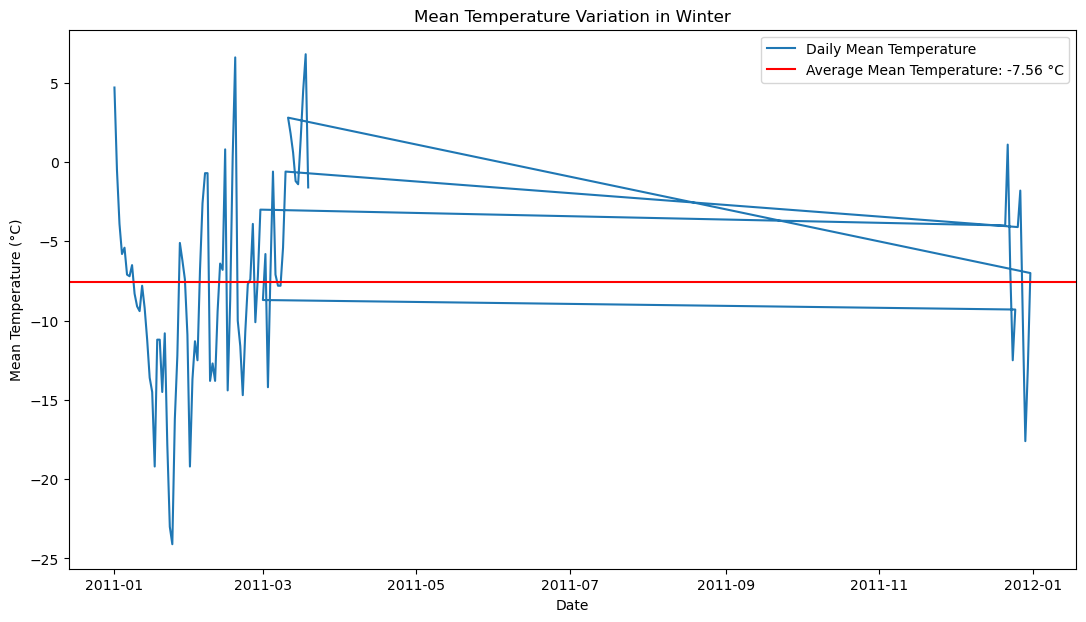

In [60]:
import matplotlib.pyplot as plt

# Function to plot the mean temperature variation for each season
def plot_seasonal_temps(data, season):
    # Filter data for the selected season
    season_data = data[data['SEASON'] == season]

    # Create the plot
    plt.figure(figsize=(13, 7))
    plt.plot(season_data['LOCAL_DATE'], season_data['MEAN_TEMPERATURE'], label='Daily Mean Temperature')
    plt.axhline(y=seasonal_avg[season], color='r', linestyle='-', label=f'Average Mean Temperature: {seasonal_avg[season]:.2f} °C')
    plt.title(f'Mean Temperature Variation in {season}')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (°C)')
    plt.legend()
    plt.show()

# Plot temperature variation for each season
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    plot_seasonal_temps(hdf1, season)

### Summary of the above output:

The seasonal analysis revealed the following:
- Distinct temperature profiles for Spring, Summer, Autumn, and Winter.
- Average mean temperatures for each season provided a benchmark for comparing daily temperature variations.
- The plots highlighted the warming trend from spring to summer and the cooling trend as autumn transitions to winter.

This part of the analysis was particularly enlightening, offering a segmented view of the year's temperature patterns and emphasizing the unique characteristics of each season in Ottawa.

## Concluding Remarks

This comprehensive analysis of Ottawa's 2011 climate data has provided us with a multi-faceted understanding of the area's meteorological patterns. Through a combination of temperature trend visualizations, precipitation analysis, geospatial mapping, and seasonal temperature breakdowns, we have gained valuable insights into both the macro and micro aspects of Ottawa's climate. The use of interactive visual tools and statistical calculations has allowed us to not just present data, but also to narrate the story behind it, revealing the climatic nuances of Ottawa, ON, in 2011.

### REFERENCES:

https://geopy.readthedocs.io/en/stable/
    
https://github.com/geopython/OWSLib
    
https://matplotlib.org/stable/plot_types/index.html

https://pandas.pydata.org/docs/reference/index.html